# Income Prediction: Random Forest model

Build, train, and test a Random Forest model to predict whether a person's income is greater than or equal to \$50k or less than \$50k based on a few features collected from United States Census data. This is a binary classifier.

In [1]:
CSV_FILE_TYPE = 'csv'
PARQUET_FILE_TYPE = 'parquet'
PARQUET_ENGINE = 'pyarrow'
DATA_FILE_TYPE = PARQUET_FILE_TYPE  # or CSV_FILE_TYPE
CLEANED_DATASET_PATH = f'../data/adult_income_cleaned.{DATA_FILE_TYPE}'
MODEL_PATH = './adult_income_random_forest_model.pkl'

In [2]:
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

# Ensures reproducibility
np.random.seed(17) 

# Disables warnings
import warnings  
warnings.filterwarnings("ignore")

In [3]:
# Reads raw data from a local file.
if DATA_FILE_TYPE == PARQUET_FILE_TYPE:
    df = pd.read_parquet(
        CLEANED_DATASET_PATH,
        engine=PARQUET_ENGINE,
    )
elif DATA_FILE_TYPE == CSV_FILE_TYPE:
    df = pd.read_csv(CLEANED_DATASET_PATH)
else:
    raise Exception(f"Unexpected {DATA_FILE_TYPE=}. Use one of ['{PARQUET_FILE_TYPE}', '{CSV_FILE_TYPE}'] instead.")
print(f"Dataframe loaded from: {CLEANED_DATASET_PATH}")

Dataframe loaded from: ../data/adult_income_cleaned.parquet


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        47879 non-null  object
 2   final_weight     48842 non-null  int64 
 3   education        48842 non-null  object
 4   education_level  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       47876 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   sex              48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   48568 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## Feature Engineering

- Removes 'final_weight' feature, because the definition is unclear.
- Removes 'education' feature, because it duplicates 'educational_level'.

In [5]:
DROPPABLE_COLUMNS = ['final_weight', 'education']

In [6]:
df.drop(DROPPABLE_COLUMNS, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        47879 non-null  object
 2   education_level  48842 non-null  int64 
 3   marital_status   48842 non-null  object
 4   occupation       47876 non-null  object
 5   relationship     48842 non-null  object
 6   race             48842 non-null  object
 7   sex              48842 non-null  object
 8   capital_gain     48842 non-null  int64 
 9   capital_loss     48842 non-null  int64 
 10  hours_per_week   48842 non-null  int64 
 11  native_country   48568 non-null  object
 12  income           48842 non-null  object
dtypes: int64(5), object(8)
memory usage: 4.8+ MB


## Training split

In [7]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]  
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)
print(f"{X_train.shape=}\n{X_valid.shape=}")

X_train.shape=(36631, 12)
X_valid.shape=(12211, 12)


## Preprocessor

Preprocessor is used to transform column values before the data is passed to the model. For example, to convert categorical data to integers.

In [8]:
numeric_features = ['age', 'capital_gain', 'capital_gain', 'hours_per_week']
ordinal_category_features = ['education_level']
nominal_category_features = ['occupation', 'workclass', 'marital_status', 'race', 'sex']

In [9]:
# Define preprocessor for independent variables.
preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(dtype=np.int64), ordinal_category_features),
        ("nominal", OneHotEncoder(dtype=np.int64, drop='first'), nominal_category_features),
        ("numeric", "passthrough", numeric_features),
    ],
)

## Build the model

In [10]:
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
)

## Train the model

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(dtype=<class 'numpy.int64'>),
                                                  ['education_level']),
                                                 ('nominal',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int64'>),
                                                  ['occupation', 'workclass',
                                                   'marital_status', 'race',
                                                   'sex']),
                                                 ('numeric', 'passthrough',
                                                  ['age', 'capital_gain',
                                                   'capital_gain',
                                                   'hours_per_week'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

## Evaluate the model

In [12]:
y_pred_proba = model.predict_proba(X_valid)[:, 1]

In [13]:
# Computes AUC score.
auc_score = roc_auc_score(y_valid, y_pred_proba)
f"{auc_score=:.5f}"

'auc_score=0.89769'

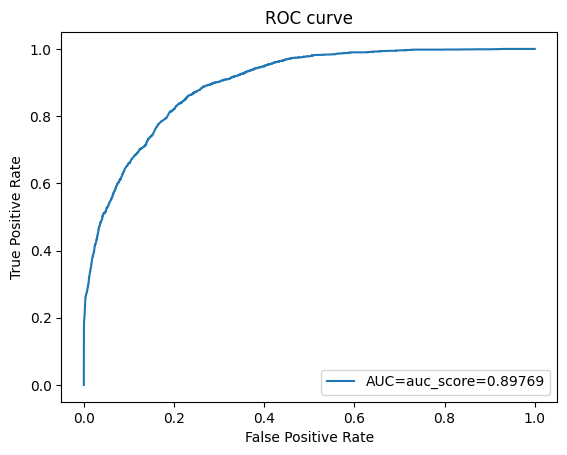

In [14]:
# Plots the ROC curve.
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba, pos_label='>50K')
plt.figure()
plt.plot(fpr, tpr, label="AUC="+f"{auc_score=:.5f}")
plt.title("ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
# plt.savefig('roc.png')

## Save the model to a local file

In [15]:
import pickle
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)
f'Model saved to: {MODEL_PATH}'

'Model saved to: ./adult_income_random_forest_model.pkl'